## Inverse Methods Project Workspace
### Eve Chase

In this notebook, I test several implementations of the statistical methodology presented in the paper "Counting and Confusion: Bayesian Rate Estimation with Multiple Populations" by Farr, Gair, Mandel, & Cutler, colloquially known as FGMC.

This methology allows you to infer the rate of astrophysical events (as opposed to noise) detected by gravitational-wave observatories, given a set of triggers with known signal to noise ratios (SNRs). 

In [1]:
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import rates_tools as rt
from scipy.special import erfc

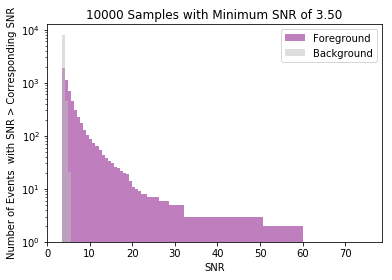

Number of Foreground:  1935
Number of Backgruond: 8065


In [2]:
# Set known parameters (Example 1 of FGMC paper)
num_samples = 10000
# rate_f = 10.4
# rate_b = 95.1

rate_f = 1930
rate_b = num_samples - rate_f
xmin = 3.5

collection = rt.SampleCollection(rate_f, rate_b, xmin)
collection.draw_samples(num_samples)
collection.plot_hist()
#collection.plot_cdf()


# Check Distributions
Check that the foreground and background distributions correspond to the expected distributions

/Users/eachase/miniconda3/envs/ligo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


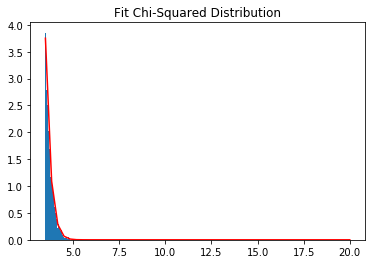

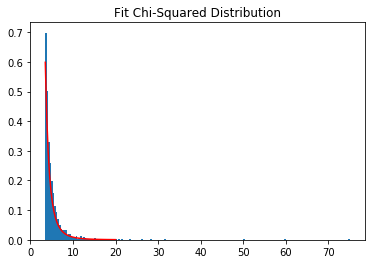

In [3]:
xrange = np.linspace(xmin, 20)

plt.figure()
bins = plt.hist(collection.background, bins=100, normed=True)
plt.plot(xrange, (np.sqrt(np.pi/2) * erfc(xmin / np.sqrt(2)))**(-1) * np.exp(-xrange**2 / 2), 'r')
plt.title('Fit Chi-Squared Distribution')
plt.show()

plt.figure()
bins = plt.hist(collection.foreground, bins=200, normed=True)
plt.plot(xrange, bins[0][0] * 3 * xmin**3 / xrange **4, 'r')
plt.title('Fit Chi-Squared Distribution')
plt.show()

## MCMC
Use an MCMC to with the FGMC methodology to find the underlying rates of foreground and background events.

In [4]:
# Draw from overall samples, assuming we don't know R_f and R_b
all_samples = np.asarray(collection.foreground + collection.background)

pos_true = [rate_f, rate_b]

ndim = 2
nwalkers=100

# Make initial guesses with dimensions (2 x nwalkers) -- FIXME: do this better
pos_init = [100 * np.random.rand(ndim) for i in np.arange(nwalkers)]

np.seterr(invalid='raise')

sampler = emcee.EnsembleSampler(nwalkers, ndim, rt.lnprob, args=[all_samples, xmin])    
sampler.run_mcmc(pos_init, 200)  
post_samples = sampler.chain[:, 50:, :].reshape((-1, ndim))    


/Users/eachase/miniconda3/envs/ligo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


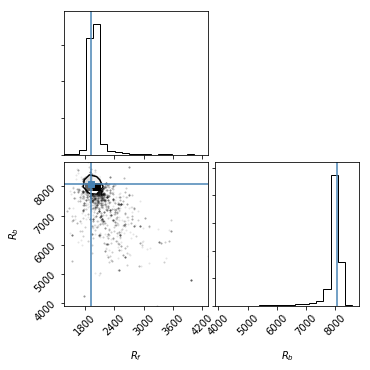

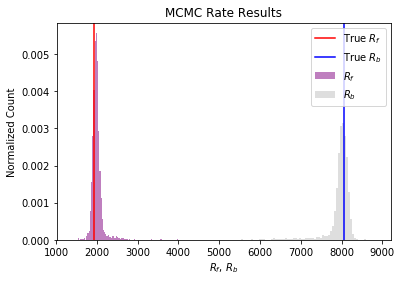

In [6]:
true_f = len(all_samples) * rate_f / (rate_f + rate_b)
true_b = len(all_samples) * rate_b / (rate_f + rate_b)

fig = corner.corner(post_samples, labels=["$R_f$", "$R_b$"], truths=[true_f , true_b])    

# plt.figure()
# plt.plot(sampler.chain[:, 50:, 0], color='k', alpha=0.2)
# plt.show()


# plt.figure()
# plt.plot(sampler.chain[:, 50:, 1], color='k', alpha=0.2, lw=0.5)
# plt.show()


plt.figure()
plt.hist(post_samples[:,0], bins=100, label=r'$R_{f}$', color='purple', alpha=0.5, normed=True)
plt.hist(post_samples[:,1], bins=100, label=r'$R_{b}$', color='0.75', alpha=0.5, normed=True)
plt.axvline(x=true_f, c='r', label=r'True $R_{f}$')
plt.axvline(x=true_b, c='b', label=r'True $R_{b}$')
plt.xlabel(r'$R_f$, $R_b$')
plt.ylabel('Normalized Count')
plt.title('MCMC Rate Results')
plt.legend(loc='upper right')
#plt.xlim(0,140)
plt.show()
